In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# IMPORTS:

In [35]:
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg19 import VGG19
from keras import layers
from keras import models
import matplotlib.pyplot as plt

In [36]:
img_height = 224
img_width = 224
batch_size=32
data_dir= '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/'

# LOADING DATA:

In [37]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  shuffle=True,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.


In [38]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  shuffle=True,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.
Using 1043 files for validation.


# Calculating class weights: (imbalanced dataset)

In [39]:
COUNT_NORMAL=1341
COUNT_PNEUMONIA=3875
TRAIN_IMG_COUNT=COUNT_PNEUMONIA+COUNT_NORMAL

In [40]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

# Visualizing a few examples

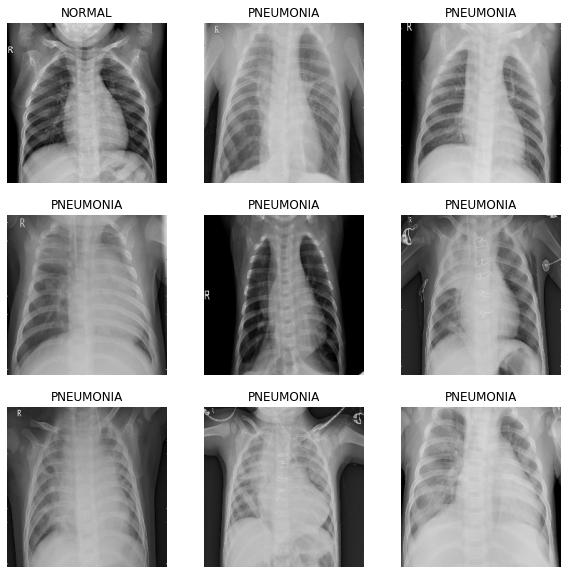

In [41]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Defining the model:

In [43]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [44]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

Model inspired by this article:
https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8

In [45]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(img_height,img_width, 3)),

    tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(),

    conv_block(32),
    conv_block(64),

    conv_block(128),
    tf.keras.layers.Dropout(0.2),

    conv_block(256),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    dense_block(512, 0.7),
    dense_block(128, 0.5),
    dense_block(64, 0.3),

    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()])

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
sequential_32 (Sequential)   (None, 56, 56, 32)        2160      
_________________________________________________________________
sequential_33 (Sequential)   (None, 28, 28, 64)        7392      
_________________________________________________________________
sequential_34 (Sequential)   (None, 14, 14, 128)       27072     
_________________________________________________________________
dropout_20 (Dropout)         (None, 14, 14, 128)     

# Evalution:

In [47]:
history=model.fit(train_ds,validation_data=val_ds,epochs=15, class_weight=class_weight)

Epoch 1/15
131/131 [==============================] - 35s 246ms/step - loss: 0.4766 - binary_accuracy: 0.7498 - precision_4: 0.9384 - recall_4: 0.7057 - val_loss: 0.6903 - val_binary_accuracy: 0.7766 - val_precision_4: 0.7766 - val_recall_4: 1.0000
Epoch 2/15
131/131 [==============================] - 33s 240ms/step - loss: 0.3186 - binary_accuracy: 0.8411 - precision_4: 0.9808 - recall_4: 0.7993 - val_loss: 0.6665 - val_binary_accuracy: 0.7766 - val_precision_4: 0.7766 - val_recall_4: 1.0000
Epoch 3/15
131/131 [==============================] - 32s 235ms/step - loss: 0.2594 - binary_accuracy: 0.8780 - precision_4: 0.9845 - recall_4: 0.8473 - val_loss: 0.6241 - val_binary_accuracy: 0.7766 - val_precision_4: 0.7766 - val_recall_4: 1.0000
Epoch 4/15
131/131 [==============================] - 33s 240ms/step - loss: 0.2248 - binary_accuracy: 0.9006 - precision_4: 0.9843 - recall_4: 0.8786 - val_loss: 0.4963 - val_binary_accuracy: 0.7766 - val_precision_4: 0.7766 - val_recall_4: 1.0000
Epoc

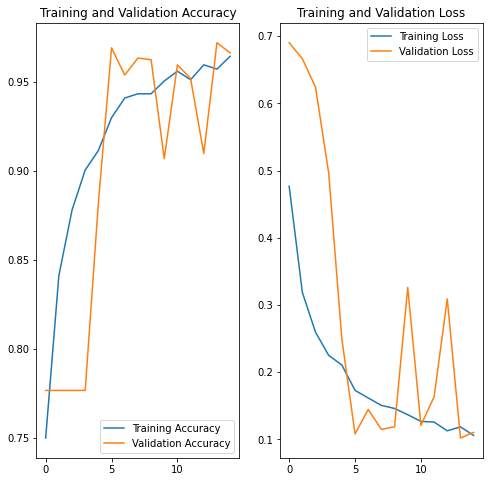

In [48]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()